# Library

In [1]:
# Installation
%pip install --quiet mesa

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from tabulate import tabulate

import math
import random

# Class Definition

## Agent

In [3]:
class ChartistAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned, chartist_day_reference):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.n = chartist_day_reference
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0
        self.buy_price = 0
        
        # Default Rule : EMA for both opening and closing
        self.is_open_sma_high = False
        self.is_close_sma_high = False
        
        if (np.random.uniform() <= 0.25):
            # Rule : SMA for both opening and closing             
            self.is_open_sma_high = True
            self.is_close_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.5):
            # Rule : SMA for opening and EMA for closing
            self.is_open_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.75):
            # Rule : EMA for opening and SMA for closing
            self.is_close_sma_high = True
    
    def step(self):
        if self.is_close:
            # Potential Buy
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()
            
            # Count Probability to Buy Based on Rule
            probability_to_buy = 0
            if self.model.price < sma_value:
                probability_to_buy += (0.8 if self.is_open_sma_high else 0.2)
            
            if self.model.price > ema_value:
                probability_to_buy += (0.8 if not self.is_open_sma_high else 0.2)
            
            # Actual Buy
            if (np.random.uniform() <= probability_to_buy):
                self.is_close = False
                
                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += self.bitcoin * self.model.price
                
                self.buy_price = self.model.price

                if (self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent += 1
                elif (self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent += 1
                elif (not self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent += 1
                elif (not self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent += 1
    
        else:
            # Potential Sell
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()

            # Count Probability to Sell Based on Rule
            probability_to_sell = 0
            if self.model.price > sma_value:
                probability_to_sell += (0.8 if self.is_close_sma_high else 0.2)
            
            if self.model.price < ema_value:
                probability_to_sell += (0.8 if not self.is_close_sma_high else 0.2)
    
            
            # Actual Sell
            if (np.random.uniform() <= probability_to_sell):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += self.bitcoin * self.model.price
                
                self.buy_price = 0
                
                if (self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent -= 1
                elif (self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent -= 1
                elif (not self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent -= 1
                elif (not self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent -= 1
        
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0
                    
    # Agent Helper Function
    # SMA Rule
    def calculate_sma_n_days(self):
        start_index = max(0, len(self.model.price_history) - self.n)
        window = self.model.price_history[start_index:len(self.model.price_history)]

        return sum(window) / len(window)

    # EMA Rule
    def calculate_ema_n_days(self):
        smooth_factor = 2 / (self.n + 1)
        
        last_n_price = pd.Series(self.model.price_history[len(self.model.price_history) - self.n:])
        
        ema = last_n_price.ewm(alpha=smooth_factor, adjust=False).mean()

        return float(ema.tail(1))

In [4]:
class RandomAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0
    
    def step(self):
        if self.is_close:
            # Actual Buy
            if (np.random.uniform() <= 0.5):
                self.is_close = False

                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += self.bitcoin * self.model.price
                self.model.number_of_open_position_random_agent += 1
    
        else:
            # Actual Sell
            if (np.random.uniform() <= 0.5):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += self.bitcoin * self.model.price
                self.model.number_of_open_position_random_agent -= 1

        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0

In [5]:
import random

class BitcoinMarketModel(mesa.Model):
    def __init__(self, chartist_day_reference):
        self.schedule = mesa.time.RandomActivation(self)
        
        # Init
        price_start = 5614
        self.price = price_start
        self.price_history = [price_start]
        self.number_of_agents = 56 
        
        self.total_fiat = 70056
        self.total_bitcoin = 54.4249
        self.supply = 0
        self.demand = 0
        
        self.number_of_open_position_R1R1_agent = 0
        self.number_of_open_position_R1R2_agent = 0
        self.number_of_open_position_R2R1_agent = 0
        self.number_of_open_position_R2R2_agent = 0
        self.number_of_open_position_random_agent = 0

        # For Intermediary Process
        self.steps = 0
        self.agents = []
        
        self.chartist_ratio = 0.6
        self.initial_fiat_owned = self.total_fiat / self.number_of_agents
        self.chartist_day_reference = chartist_day_reference
        
        # For Batch Run         
        self.running = True
        
        number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
        number_of_random = self.number_of_agents - number_of_chartist
        fiat_owned = self.initial_fiat_owned
        bitcoin_owned = 0

        for i in range(number_of_chartist):
            a = ChartistAgent(str(f"chartist-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned, 
                              chartist_day_reference)

            self.schedule.add(a)
            self.agents.append(a)
        
        for i in range(number_of_random):
            a = RandomAgent(str(f"random-{i}"), 
                          self, 
                          fiat_owned,
                          bitcoin_owned)

            self.schedule.add(a)
            self.agents.append(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"Price": "price", 
                             "Number_of_agents": "number_of_agents", 
                             "Open_R1R1": "number_of_open_position_R1R1_agent", 
                             "Open_R1R2": "number_of_open_position_R1R2_agent", 
                             "Open_R2R1": "number_of_open_position_R2R1_agent", 
                             "Open_R2R2": "number_of_open_position_R2R2_agent", 
                             "Open_Random": "number_of_open_position_random_agent"}, 
            agent_reporters={"Fiat": "fiat", 
                             "Bitcoin": "bitcoin", 
                             "TOV": "total_value_obtained", 
                             "RBF": "ratio_bitcoin_fiat",
                             "OpenSMA": "is_open_sma_high", 
                             "CloseSMA": "is_close_sma_high"}
        )
    
    def step(self):
        # Before Stepping
        self.price += self.calculate_today_price_change()
        self.supply = 0
        self.demand = 0
        
        self.datacollector.collect(self)
        
        # Stepping
        self.schedule.step()
        self.steps += 1
        
        # After Stepping
        self.price_history.append(self.price)
        
        # Monthly Adjustment
        if (self.steps % 30 == 0):
            # Add New Agents
            old_number_of_agents = self.number_of_agents
            self.number_of_agents += math.floor(0.02 * self.number_of_agents)
            
            number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
            number_of_random = self.number_of_agents - number_of_chartist
            fiat_owned = self.initial_fiat_owned
            bitcoin_owned = 0
            chartist_day_reference = self.chartist_day_reference
            
            for i in range(number_of_chartist):
                a = ChartistAgent(str(f"add-chartist-{i}-at-{self.steps}"), 
                                  self, 
                                  fiat_owned,
                                  bitcoin_owned, 
                                  chartist_day_reference)

                self.schedule.add(a)
                self.agents.append(a)

            for i in range(number_of_random):
                a = RandomAgent(str(f"add-random-{i}-at-{self.steps}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned)

                self.schedule.add(a)
                self.agents.append(a)
                    
            # Add New Bitcoins to Traders
            valuable_agents = []
            total_value_in_agents = 0
            for i in range(len(self.agents)):
                agent = self.agents[i]
                total_value_in_agents += agent.total_value_obtained
                
                if (np.random.uniform() <= 0.5):
                    valuable_agents.append(agent)

            
            total_new_bitcoin = round(0.076 * self.total_bitcoin, 4)
            self.total_bitcoin += total_new_bitcoin
            
            for i in range(len(valuable_agents)):
                agent = valuable_agents[i]
                
                ratio = agent.total_value_obtained / total_value_in_agents
                
                agent.bitcoin += round(ratio * total_new_bitcoin, 4)
        
    # Model Helper Function
    # Calculate Price
    def calculate_today_price_change(self):
        supply_demand_difference = self.demand - self.supply
        sign = math.copysign(1, supply_demand_difference)
        result = math.floor((math.sqrt(2) / 2) * sign *  math.sqrt(abs(supply_demand_difference)))
        
        return result

# Task 2 SIMULATION

In [6]:
# Agents Parameters
params = {"chartist_day_reference": [1,2,3,5,7,9]}

max_steps = 500

results = mesa.batch_run(
    BitcoinMarketModel,
    parameters=params,
    iterations=2,
    number_processes=1,
    max_steps=max_steps,
    data_collection_period=3,
    display_progress=True,
)

results_df = pd.DataFrame(results)
# print(results_df)

  0%|          | 0/12 [00:00<?, ?it/s]

## Task 2.1 Effect of n in Chartist Strategy

In [7]:
results_chartist_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
results_chartist_df = results_chartist_df[(results_chartist_df.Step == max_steps)]

# print(results_chartist_df)

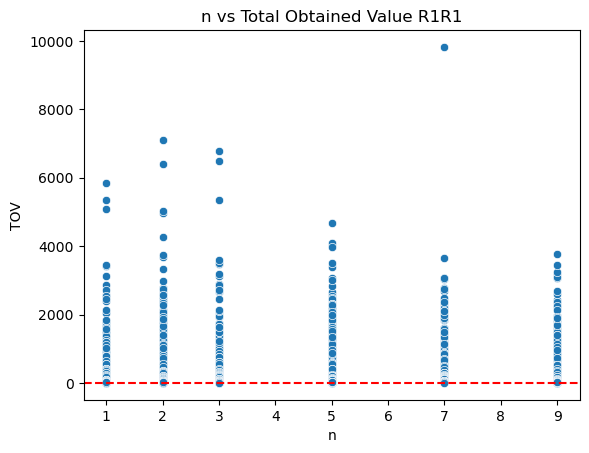

                          TOV Mean      TOV SD    TOV Max  TOV Min
chartist_day_reference                                            
1                       648.230914  767.237964  5843.9463   0.0000
2                       742.012088  959.613474  7111.4640   5.7477
3                       629.704177  849.415040  6765.5361   0.0000
5                       737.483602  817.491190  4661.2179   4.6216
7                       727.513269  885.068396  9821.7238   5.0133
9                       613.471681  688.847877  3764.4109   9.7913


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                           29.675841     2.497630
2                           29.570978     4.506554
3                           41.955490     3.004130
5                           31.101227     6.497730
7                           29.292208     4.999577
9                           27.426866     3.504470


In [8]:
results_chartist_R1R1_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R1_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.CloseSMA == True)]

g_R1R1 = sns.scatterplot(data=results_chartist_R1R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R1_df = avg_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R1_df = sd_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R1R1_df = max_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R1R1_df = min_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R1R1_df = avg_TVO_per_n_R1R1_df.merge(sd_TVO_per_n_R1R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R1_df = aggregated_TVO_per_n_R1R1_df.merge(max_TVO_per_n_R1R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R1_df = aggregated_TVO_per_n_R1R1_df.merge(min_TVO_per_n_R1R1_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R1'])
avg_open_pos_per_n_R1R1_df = avg_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos Mean'})
sd_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R1'])
sd_open_pos_per_n_R1R1_df = sd_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos SD'})

print(aggregated_TVO_per_n_R1R1_df)
print('\n')
print(avg_open_pos_per_n_R1R1_df.merge(sd_open_pos_per_n_R1R1_df, on='chartist_day_reference',how='left'))


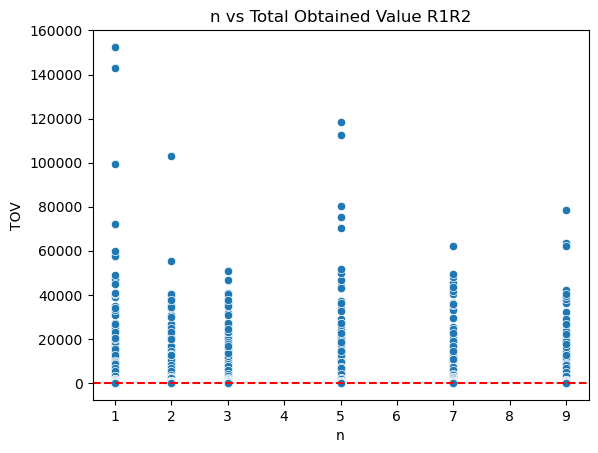

                           TOV Mean        TOV SD      TOV Max  TOV Min
chartist_day_reference                                                 
1                       6855.878231  15558.804747  152524.9221  17.1985
2                       4911.327250   9392.742132  102929.1276   9.5574
3                       5361.228591   8635.538050   50934.2415   0.0000
5                       6210.360639  13386.479334  118579.1352   0.0000
7                       4811.142452   8837.572422   61990.8978   5.2364
9                       4831.019810   9193.383042   78437.7522   9.8852


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                           85.008130     7.492927
2                          103.000000     0.000000
3                           96.957507     5.006916
5                           88.601078     7.509446
7                           78.164179     5.004779
9                           89.788889     6.502615


In [9]:
results_chartist_R1R2_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R2_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.CloseSMA == False)]

g_R1R2 = sns.scatterplot(data=results_chartist_R1R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R2_df = avg_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R2_df = sd_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R1R2_df = max_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R1R2_df = min_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R1R2_df = avg_TVO_per_n_R1R2_df.merge(sd_TVO_per_n_R1R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R2_df = aggregated_TVO_per_n_R1R2_df.merge(max_TVO_per_n_R1R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R2_df = aggregated_TVO_per_n_R1R2_df.merge(min_TVO_per_n_R1R2_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R2'])
avg_open_pos_per_n_R1R2_df = avg_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos Mean'})
sd_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R2'])
sd_open_pos_per_n_R1R2_df = sd_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos SD'})

print(aggregated_TVO_per_n_R1R2_df)
print('\n')
print(avg_open_pos_per_n_R1R2_df.merge(sd_open_pos_per_n_R1R2_df, on='chartist_day_reference',how='left'))

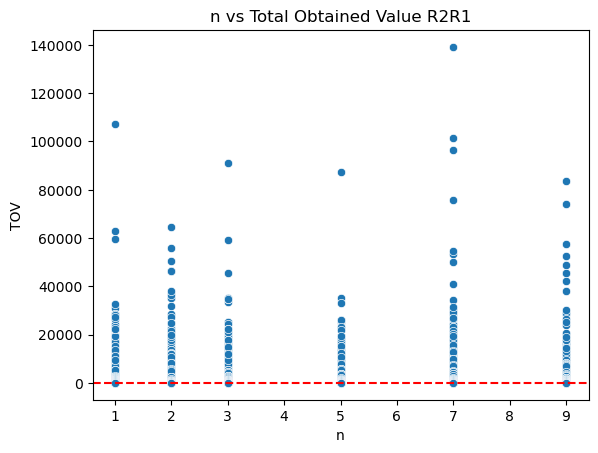

                           TOV Mean        TOV SD      TOV Max  TOV Min
chartist_day_reference                                                 
1                       4706.051027   9544.805199  107141.1648  40.6999
2                       5491.226388   9267.690674   64518.8875  41.8916
3                       4414.385677   8477.773435   91076.1655  42.7064
5                       4072.877136   7240.863149   87345.1266  35.2948
7                       5839.945288  13308.659892  139162.0005  33.7554
9                       5651.088415  10362.068234   83554.4522  38.1611


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                           84.000000     3.004584
2                           84.000000     0.000000
3                           88.175439     5.004243
5                           90.039106     1.000634
7                           89.871795     5.005491
9                           85.951220     2.002460


In [10]:
results_chartist_R2R1_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R1_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.CloseSMA == True)]

g_R2R1 = sns.scatterplot(data=results_chartist_R2R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R1_df = avg_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R1_df = sd_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R2R1_df = max_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R2R1_df = min_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R2R1_df = avg_TVO_per_n_R2R1_df.merge(sd_TVO_per_n_R2R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R1_df = aggregated_TVO_per_n_R2R1_df.merge(max_TVO_per_n_R2R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R1_df = aggregated_TVO_per_n_R2R1_df.merge(min_TVO_per_n_R2R1_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R1'])
avg_open_pos_per_n_R2R1_df = avg_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos Mean'})
sd_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R1'])
sd_open_pos_per_n_R2R1_df = sd_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos SD'})

print(aggregated_TVO_per_n_R2R1_df)
print('\n')
print(avg_open_pos_per_n_R2R1_df.merge(sd_open_pos_per_n_R2R1_df, on='chartist_day_reference',how='left'))

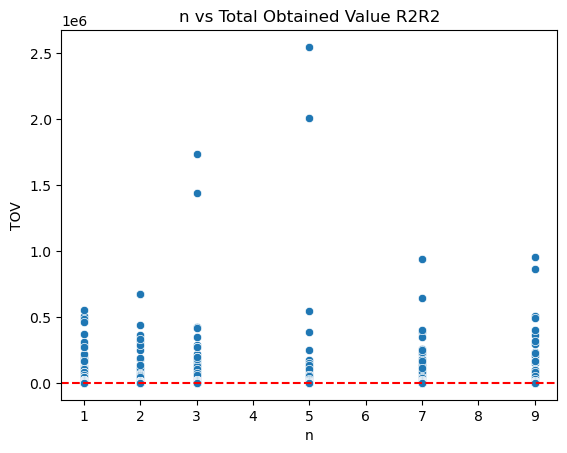

                            TOV Mean         TOV SD       TOV Max  TOV Min
chartist_day_reference                                                    
1                       31205.137347   80237.741029  5.505633e+05  65.5261
2                       28678.436394   81693.856402  6.770539e+05  46.7696
3                       38776.366898  149855.388039  1.731909e+06  60.3794
5                       40904.379071  215446.972261  2.544653e+06  61.3357
7                       29621.313107   84855.331575  9.413608e+05  60.3492
9                       36918.215297  104284.045636  9.541992e+05  65.4701


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                          103.473881     3.506451
2                          103.000000     0.000000
3                          103.038462     1.001187
5                           97.278481     6.006219
7                          121.020134     3.004979
9                          103.728625    

In [11]:
results_chartist_R2R2_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R2_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.CloseSMA == False)]

g_R2R2 = sns.scatterplot(data=results_chartist_R2R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R2_df = avg_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R2_df = sd_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R2R2_df = max_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R2R2_df = min_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R2R2_df = avg_TVO_per_n_R2R2_df.merge(sd_TVO_per_n_R2R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R2_df = aggregated_TVO_per_n_R2R2_df.merge(max_TVO_per_n_R2R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R2_df = aggregated_TVO_per_n_R2R2_df.merge(min_TVO_per_n_R2R2_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R2'])
avg_open_pos_per_n_R2R2_df = avg_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos Mean'})
sd_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R2'])
sd_open_pos_per_n_R2R2_df = sd_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos SD'})

print(aggregated_TVO_per_n_R2R2_df)
print('\n')
print(avg_open_pos_per_n_R2R2_df.merge(sd_open_pos_per_n_R2R2_df, on='chartist_day_reference',how='left'))

## Task 2.2 Agent Comparisons

In [22]:
best_n_R1R1 = 5
best_n_R1R2 = 1
best_n_R2R1 = 7
best_n_R2R2_recent = 5
best_n_R2R2_older = 5

results_chartist_R1R1__best_n_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.chartist_day_reference == best_n_R1R1)]
results_chartist_R1R2__best_n_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.chartist_day_reference == best_n_R1R2)]
results_chartist_R2R1__best_n_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.chartist_day_reference == best_n_R2R1)]
results_chartist_R2R2_recent__best_n_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.chartist_day_reference == best_n_R2R2_recent)]
results_chartist_R2R2_older__best_n_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.chartist_day_reference == best_n_R2R2_older)]

results_random_df = results_df[(results_df["AgentID"].str.contains("random"))]
results_random_df = results_random_df[(results_random_df.Step == max_steps)]
results_random_best_n_df = results_random_df[(results_random_df.chartist_day_reference == best_n_R1R1)]

# print(results_chartist_R1R1__best_n_df.head(3))

In [23]:
print('TOV Statistics')
summary_TOV = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2-Recent', 'R2R2-Older', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R2_recent__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R2_older__best_n_df.mean(numeric_only=True)['TOV'],
           results_random_best_n_df.mean(numeric_only=True)['TOV']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R2_recent__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R2_older__best_n_df.std(numeric_only=True)['TOV'], 
           results_random_best_n_df.std(numeric_only=True)['TOV']]
})
print(summary_TOV)

fig = px.histogram(summary_TOV, x="Agent Name" , y=["Avg"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for TOV Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

TOV Statistics
    Agent Name           Avg             SD
0         R1R1    737.483602     817.491190
1         R1R2   6855.878231   15558.804747
2         R2R1   5839.945288   13308.659892
3  R2R2-Recent  40904.379071  215446.972261
4   R2R2-Older  40904.379071  215446.972261
5       Random   5049.238590    9302.313255


In [24]:
print('Open Position Statistics')
summary_open_pos = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2-Recent', 'R2R2-Older', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['Open_R1R1'], 
            results_chartist_R1R2__best_n_df.mean(numeric_only=True)['Open_R1R2'],
            results_chartist_R2R1__best_n_df.mean(numeric_only=True)['Open_R2R1'], 
            results_chartist_R2R2_recent__best_n_df.mean(numeric_only=True)['Open_R2R2'], 
            results_chartist_R2R2_older__best_n_df.mean(numeric_only=True)['Open_R2R2'],
            results_random_best_n_df.mean(numeric_only=True)['Open_Random']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['Open_R1R1'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['Open_R1R2'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['Open_R2R1'],
           results_chartist_R2R2_recent__best_n_df.std(numeric_only=True)['Open_R2R2'], 
           results_chartist_R2R2_older__best_n_df.std(numeric_only=True)['Open_R2R2'], 
           results_random_best_n_df.std(numeric_only=True)['Open_Random']]
})
print(summary_open_pos)

fig = px.histogram(summary_open_pos, x="Agent Name" , y=["Avg"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Open Position Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

Open Position Statistics
    Agent Name         Avg        SD
0         R1R1   31.101227  6.497730
1         R1R2   85.008130  7.492927
2         R2R1   89.871795  5.005491
3  R2R2-Recent   97.278481  6.006219
4   R2R2-Older   97.278481  6.006219
5       Random  216.000000  5.002830


In [25]:
print('Ratio Bitcoin vs Fiat')
summary_ratio = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2-Recent', 'R2R2-Older', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R2_recent__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R2_older__best_n_df.mean(numeric_only=True)['RBF'],
           results_random_best_n_df.mean(numeric_only=True)['RBF']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R2_recent__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R2_older__best_n_df.std(numeric_only=True)['RBF'], 
           results_random_best_n_df.std(numeric_only=True)['RBF']]
})
print(summary_ratio)

fig = px.histogram(summary_ratio, x="Agent Name" , y=["Avg"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Bitcoin:Fiat Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

Ratio Bitcoin vs Fiat
    Agent Name       Avg        SD
0         R1R1  0.000123  0.001750
1         R1R2  0.003550  0.021673
2         R2R1  0.001453  0.005942
3  R2R2-Recent  0.064684  0.653708
4   R2R2-Older  0.064684  0.653708
5       Random  0.002602  0.020023


# Task 3 Model Validation

In [26]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_price_df = results_df.copy()
results_price_df = results_price_df.loc[:,["iteration", "Step", "Price"]]
results_price_df = results_price_df.groupby(['iteration', 'Step']).max()['Price']
results_price_df = results_price_df.groupby(["Step"]).mean()
# print(results_price_df.groupby(["Step"]).mean())

fig = px.line(results_price_df, y = 'Price', title = 'Price', markers = True)

fig.show()

In [27]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_open_R1R1_df = results_df.copy()


results_open_R1R1_df = results_open_R1R1_df.loc[:,["iteration", "Step", "Open_R1R1"]]
results_open_R1R1_df = results_open_R1R1_df.groupby(['iteration', 'Step']).max()['Open_R1R1']
results_open_R1R1_df = results_open_R1R1_df.groupby(["Step"]).mean()
# # print(results_price_df.groupby(["Step"]).mean())
# print(results_open_R1R1_df)
fig = px.line(results_open_R1R1_df, y = 'Open_R1R1', title = 'Open_R1R1', markers = True)

fig.show()

In [28]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_open_R1R2_df = results_df.copy()


results_open_R1R2_df = results_open_R1R2_df.loc[:,["iteration", "Step", "Open_R1R2"]]
results_open_R1R2_df = results_open_R1R2_df.groupby(['iteration', 'Step']).max()['Open_R1R2']
results_open_R1R2_df = results_open_R1R2_df.groupby(["Step"]).mean()
# # print(results_price_df.groupby(["Step"]).mean())
# print(results_open_R1R1_df)
fig = px.line(results_open_R1R2_df, y = 'Open_R1R2', title = 'Open_R1R2', markers = True)

fig.show()

In [29]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_open_R2R1_df = results_df.copy()


results_open_R2R1_df = results_open_R2R1_df.loc[:,["iteration", "Step", "Open_R2R1"]]
results_open_R2R1_df = results_open_R2R1_df.groupby(['iteration', 'Step']).max()['Open_R2R1']
results_open_R2R1_df = results_open_R2R1_df.groupby(["Step"]).mean()
# # print(results_price_df.groupby(["Step"]).mean())
# print(results_open_R1R1_df)
fig = px.line(results_open_R2R1_df, y = 'Open_R2R1', title = 'Open_R2R1', markers = True)

fig.show()

In [30]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_open_R2R2_df = results_df.copy()


results_open_R2R2_df = results_open_R2R2_df.loc[:,["iteration", "Step", "Open_R2R2"]]
results_open_R2R2_df = results_open_R2R2_df.groupby(['iteration', 'Step']).max()['Open_R2R2']
results_open_R2R2_df = results_open_R2R2_df.groupby(["Step"]).mean()
# # print(results_price_df.groupby(["Step"]).mean())
# print(results_open_R1R1_df)
fig = px.line(results_open_R2R2_df, y = 'Open_R2R2', title = 'Open_R2R2', markers = True)

fig.show()

In [21]:
# total_bitcoin = 10000
# total_fiat = 5000000

# # Agents Parameters
# number_of_agents = 5 # In 2020, there are 420M users
# chartist_day_reference = 3
# chartist_ratio = 0.5

# price_start = 5614

# model = BitcoinMarketModel(price_start, 
#                            number_of_agents, 
#                            total_fiat, 
#                            total_bitcoin, 
#                            chartist_ratio, 
#                            chartist_day_reference)

# for i in range(10):
# #     print(f'progress : {i}/1399')
#     model.step()
    
# data = model.datacollector.get_model_vars_dataframe()

# price_df = pd.DataFrame(data=data.Price)
# fig = px.line(price_df, y = 'Price', title = 'Price', markers = True)

# fig.show()

# agent_variables = model.datacollector.get_agent_vars_dataframe()
# end_state = agent_variables.index.get_level_values("Step").max()
# end_state_total_value = agent_variables.xs(end_state, level="Step")["TV"]
# agents_total_value_df = pd.DataFrame(data=end_state_total_value)

# # # Create a histogram of wealth at the last step
# counts, bins = np.histogram(agents_total_value_df, bins=range(0, 5000000, 1000000))
# bins = 0.5 * (bins[:-1] + bins[1:])

# fig = px.bar(x=bins, y=counts, labels={'x':'total_values', 'y':'count'})
# fig.show()